<a href="https://colab.research.google.com/github/saritmaitra/Mean_Reversion_Trading/blob/main/Mean_reversion_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install quandl
# import quandl

!pip install yfinance
import yfinance as yf
import datetime as dt
!pip install quandl
import quandl
from pandas import concat, DataFrame

The example starts with NG data and implements a mean-reversion strategy on the basis of an SMA of 20 days and a threshold value of 0.5 for the absolute deviation of the current price to deviate from the SMA to signal a positioning.

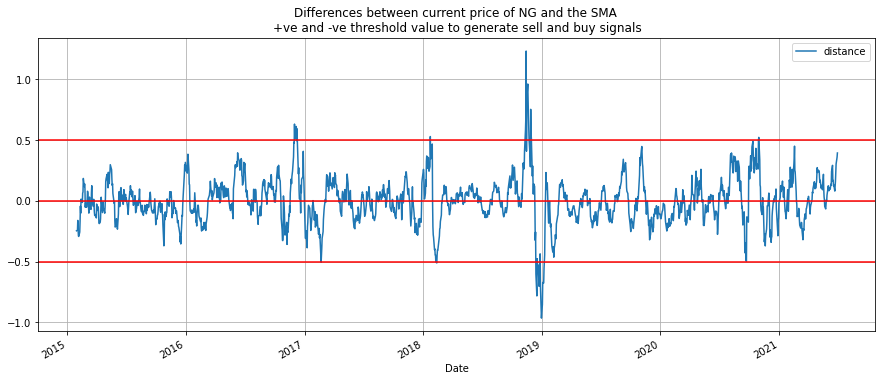

In [166]:
import numpy as np 

NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL",
                 start_date='2015-01-01',
                 ) # natural gas continuous contract 1
NG['returns'] = np.log(NG['Last'] /
                                  NG['Last'].shift(1))
SMA = 20
NG['SMA'] = NG['Last'].rolling(SMA).mean()
threshold = 0.5 
NG['distance'] = NG['Last'] - NG['SMA'] 
NG['distance'].dropna().plot(figsize=(15, 6), legend=True)  
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color='r'); 
plt.title("Differences between current price of NG and the SMA \n+ve and -ve threshold value to generate sell and buy signals");  plt.grid(True)


differences between the current price of NG and the SMA, as well as the positive and negative threshold value to generate sell and buy signals, respectively:

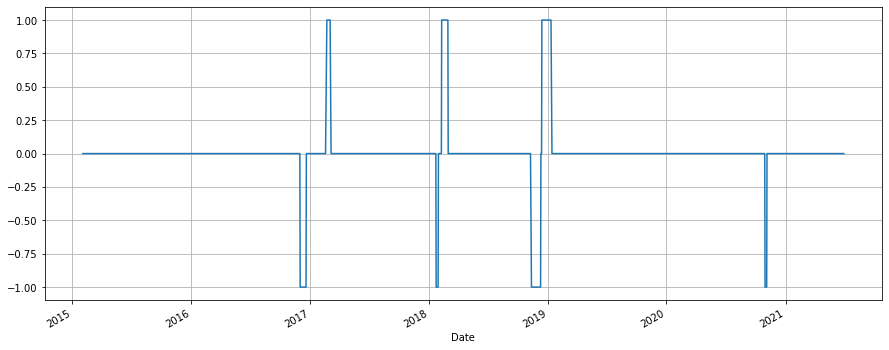

In [168]:
NG['position'] = np.where(NG['distance'] > threshold,
                                      -1, np.nan)  
NG['position'] = np.where(NG['distance'] < -threshold,
                                      1, NG['position'])  

NG['position'] = np.where(NG['distance'] *
                      NG['distance'].shift(1) < 0, 0, NG['position'])  

NG['position'] = NG['position'].ffill().fillna(0)  

NG['position'].iloc[SMA:].plot(ylim=[-1.1, 1.1],
                                         figsize=(15, 6));  
plt.grid(True)

- if the distance value is greater than the threshold value, go short (set –1 in the new column position), otherwise set NaN.
- If the distance value is lower than the negative threshold value, go long (set 1), otherwise keep the column position unchanged.
- If there is a change in the sign of the distance value, go market neutral (set 0), otherwise keep the column position unchanged.

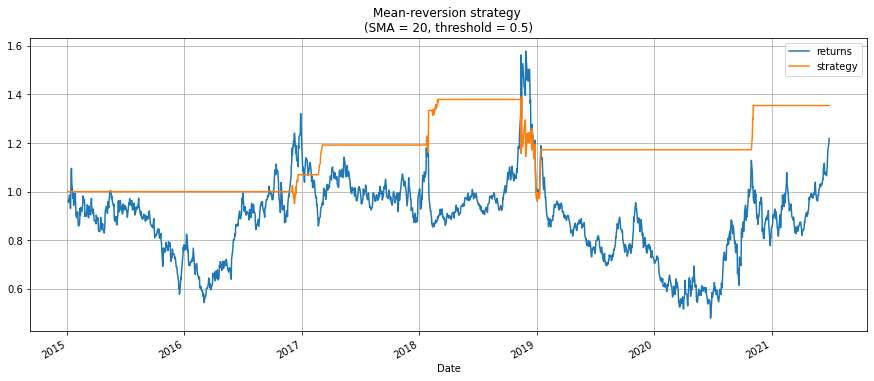

In [169]:
NG['strategy'] = NG['position'].shift(1) * NG['returns']
NG[['returns', 'strategy']].dropna().cumsum(
                  ).apply(np.exp).plot(figsize=(15, 6));
plt.title("Mean-reversion strategy \n(SMA = 20, threshold = 0.5)")
plt.grid(True)

In [172]:
# class to store tick data
class tickData(object):
  """ Stores a single unit of data """
  def __init__(self,timestamp='',symbol='',open_price=0,close_price=0,total_volume=0):
    self.symbol = symbol
    self.timestamp = timestamp
    self.open_price = open_price
    self.close_price = close_price
    self.total_volume = total_volume

In [173]:
# class to store price data
class data(object):
  def __init__(self):
    self.recent_ticks = dict() # indexed by symbol

  def add_tick_data(self, tick_data):
    self.recent_ticks[tick_data.symbol] = tick_data

  def get_open_price(self,symbol):
    return self.get_tick_data(symbol).open_price

  def get_close_price(self,symbol):
    return self.get_tick_data(symbol).close_price

  def get_tick_data(self,symbol):
    return self.recent_ticks.get(symbol, tickData())

  def get_timestamp(self,symbol):
    return self.recent_ticks[symbol].timestamp

In [174]:
# class to generate data sources
class data_source(object):
  def __init__(self, symbol, tick_event_handler = None, start='', end=''):
    self.data = data()
    self.symbol = symbol
    self.tick_event_handler = tick_event_handler
    self.start, self.end = start, end
    self.NG = None
  
  def retrieve_time_series(self): # historical Henry Hub prices
    # df = yf.download(self.symbol, start_date=self.start,end_date=self.end)
    # Update your Quandl API key here...
    QUANDL_API_KEY="LSQpgUzwJRoF667ZpzyL"
    quandl.ApiConfig.api_key=QUANDL_API_KEY
    NG = quandl.get(self.symbol, start_date = self.start, end_date = self.end)
    return NG

  def run(self):
    if self.NG is None:
      self.NG = self.retrieve_time_series()
      
    total_ticks =len(self.NG)
    print('Processing total_ticks:',total_ticks)
    
    for timestamp, row in self.NG.iterrows():
      open_price = row['Open']
      close_price = row['Last']
      volume = row['Volume']
      print(timestamp.date(),'TICK', self.symbol, 'open:', open_price, 'close:', close_price)
      tick_data = tickData(timestamp, self.symbol, open_price, close_price, volume)
      self.data.add_tick_data(tick_data)
      
      if self.tick_event_handler:
        self.tick_event_handler(self.data)

In [175]:
class Order(object):
  def __init__(self, timestamp, symbol, qty, is_buy, order, price=0):
    self.timestamp = timestamp
    self.symbol = symbol
    self.qty = qty
    self.price = price
    self.is_buy = is_buy
    self.order = order
    self.is_filled = False
    self.filled_price = 0
    self.filled_time = None
    self.filled_qty = 0

In [176]:
class Position(object):
  def __init__(self,symbol=''):
    self.symbol = symbol
    self.buys = self.sells = self.net=0
    self.retpnl = 0
    self.position_value = 0
  
  def position_event(self, is_buy, qty, price):
    if is_buy:
      self.buys += qty
    else:
      self.sells += qty
      
    self.net = self.buys - self.sells
    changed_value = qty * price * (-1 if is_buy else 1)
    self.position_value += changed_value
    
    if self.net == 0:
      self.retpnl = self.position_value
      self.position_value = 0

  def unrealized_pnl(self, price):
    if self.net == 0:
      return 0
    
    value = self.net*price
    unrpnl = self.position_value + value # unr = unrealized
    return unrpnl

In [177]:
from abc import abstractmethod

In [178]:
class Strategy:
  def __init__(self, send_order_event_handler):
    self.send_order_event_handler = send_order_event_handler
    
  @abstractmethod
  def tick_event(self, data):
    raise NotImplementedError('Method is required!')

  @abstractmethod
  def position_event(self, positions):
    raise NotImplementedError('Method is required!')

  def send_order(self, symbol, qty, is_buy, timestamp):
    if self.send_order_event_handler:
      order = Order(timestamp, symbol, qty, is_buy, order = True, price = 0,)
      self.send_order_event_handler(order)

In [179]:
import pandas as pd
# MRStrat = mean reversion strategy
class MRStrat(Strategy):
  def __init__(self, symbol, trade_qty, send_order_event_handler = None, lookback_intervals = 20, 
               buy_threshold = -0.5, sell_threshold = 0.5):
    super(MRStrat, self).__init__(send_order_event_handler)
    self.symbol = symbol
    self.trade_qty = trade_qty
    self.lookback_intervals = lookback_intervals
    self.buy_threshold = buy_threshold
    self.sell_threshold = sell_threshold
    self.prices = DataFrame()
    self.is_long = self.is_short = False
    
  def position_event(self, positions):
    position = positions.get(self.symbol)
    self.is_long = position and position.net > 0
    self.is_short = position and position.net < 0
    
  def tick_event(self, data):
    self.store_prices(data)
    
    if len(self.prices) < self.lookback_intervals:
      return 
      
    self.generate_signals_and_send_order(data)
      
  def store_prices(self, data):
    timestamp = data.get_timestamp(self.symbol)
    close_price = data.get_close_price(self.symbol)
    self.prices.loc[timestamp,'close'] = close_price

  def generate_signals_and_send_order(self, data):
    signal_value = self.calculate_z_score()
    timestamp = data.get_timestamp(self.symbol)
    
    if self.buy_threshold > signal_value and not self.is_long:
      print(timestamp.date(),'BUY signal')
      self.send_order(self.symbol, self.trade_qty, True, timestamp)
      
    elif self.sell_threshold < signal_value and not self.is_short:
      print(timestamp.date(),'SELL signal')
      self.send_order(self.symbol, self.trade_qty, False, timestamp)
      
  def calculate_z_score(self):
    self.prices = self.prices[-self.lookback_intervals:]
    returns = self.prices['close'].pct_change().dropna()
    z_score = ((returns - returns.mean()) / returns.std())[-1]
    return z_score

In [180]:
class back_test:
  def __init__(self, symbol, trade_qty, start='', end=''):
    self.symbol = symbol
    self.trade_qty = trade_qty
    self.data_source = data_source(symbol, tick_event_handler = self.tick_event, start = start, end=end)
    self.strategy = None
    self.unfilled_orders = []
    self.positions = dict()
    self.NG_retpnl = None
    
  def start(self, **kwargs):
    print('Backtest started...')
    self.unfilled_orders = []
    self.positions = dict()
    self.NG_retpnl = DataFrame()
    self.strategy = MRStrat(self.symbol, self.trade_qty, 
                            send_order_event_handler = self.order_received, **kwargs)
    self.data_source.run()
    print('---------------Backtest completed-----------------')
    
  def order_received(self, order):
    """ Adds an order to the order book """
    print(order.timestamp.date(),'ORDER', 'BUY' if order.is_buy else 'SELL', order.symbol, order.qty)
    self.unfilled_orders.append(order)
    
  def tick_event(self, data):
    self.match_order_book(data)
    self.strategy.tick_event(data)
    self.print_position_status(data)

  def match_order_book(self, data):
    if len(self.unfilled_orders) > 0:
      self.unfilled_orders = [order for order in self.unfilled_orders if self.match_unfilled_orders(order, data)]

  def match_unfilled_orders(self, order, data):
    symbol = order.symbol
    timestamp = data.get_timestamp(symbol)
    """ Order is matched and filled """
    if order.order and timestamp > order.timestamp:
      open_price = data.get_open_price(symbol)
      order.is_filled = True
      order.filled_timestamp = timestamp
      order.filled_price = open_price
      self.order_filled(symbol, order.qty, order.is_buy, open_price, timestamp)
      return False

    return True
  
  def order_filled(self, symbol, qty, is_buy, filled_price, timestamp):
    position = self.get_position(symbol)
    position.position_event(is_buy, qty, filled_price)
    self.NG_retpnl.loc[timestamp, "ret_pnl"] = position.retpnl
    self.strategy.position_event(self.positions)
    print(timestamp.date(),'FILLED',"BUY" if is_buy else "SELL", qty, symbol, 'at', filled_price)
    
  def get_position(self, symbol):
    if symbol not in self.positions:
      self.positions[symbol] = Position(symbol)
    
    return self.positions[symbol]
      
  def print_position_status(self, data):
    for symbol, position in self.positions.items():
      close_price = data.get_close_price(symbol)
      timestamp = data.get_timestamp(symbol)
      unrpnl = position.unrealized_pnl(close_price)
      print(timestamp.date(),'POSITION','value:%.3f'% position.position_value,'un-realized_pnl:%.3f'%unrpnl,'ret_pnl:%.3f'%position.retpnl)


Backtest started...
Processing total_ticks: 376
2020-01-02 TICK CHRIS/CME_NG1 open: 2.184 close: 2.13
2020-01-03 TICK CHRIS/CME_NG1 open: 2.129 close: 2.114
2020-01-06 TICK CHRIS/CME_NG1 open: 2.112 close: 2.149
2020-01-07 TICK CHRIS/CME_NG1 open: 2.149 close: 2.154
2020-01-08 TICK CHRIS/CME_NG1 open: 2.153 close: 2.151
2020-01-09 TICK CHRIS/CME_NG1 open: 2.151 close: 2.167
2020-01-10 TICK CHRIS/CME_NG1 open: 2.166 close: 2.207
2020-01-13 TICK CHRIS/CME_NG1 open: 2.21 close: 2.19
2020-01-14 TICK CHRIS/CME_NG1 open: 2.188 close: 2.179
2020-01-15 TICK CHRIS/CME_NG1 open: 2.181 close: 2.124
2020-01-16 TICK CHRIS/CME_NG1 open: 2.134 close: 2.076
2020-01-17 TICK CHRIS/CME_NG1 open: 2.077 close: 2.003
2020-01-21 TICK CHRIS/CME_NG1 open: 1.97 close: 1.908
2020-01-22 TICK CHRIS/CME_NG1 open: 1.912 close: 1.913
2020-01-23 TICK CHRIS/CME_NG1 open: 1.915 close: 1.938
2020-01-24 TICK CHRIS/CME_NG1 open: 1.938 close: 1.886
2020-01-27 TICK CHRIS/CME_NG1 open: 1.935 close: 1.896
2020-01-28 TICK CHRIS

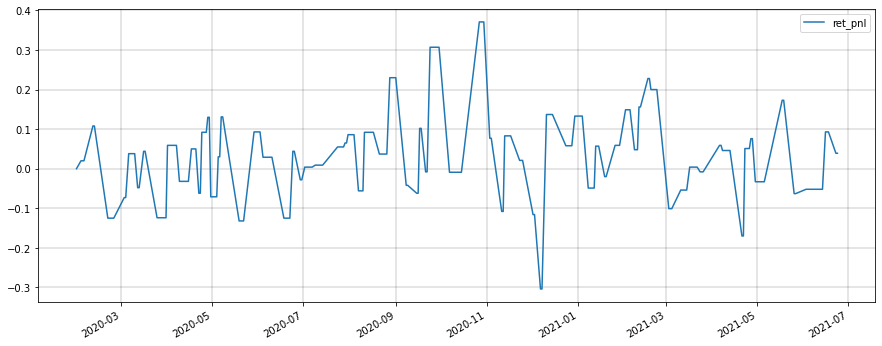

In [183]:
strategy = back_test("CHRIS/CME_NG1",1,
                      start='2020-01-01',
                      end='2021-07-09')

strategy.start(lookback_intervals = 20, buy_threshold=-0.5, sell_threshold = 0.5)
%matplotlib inline 
import matplotlib.pyplot as plt
strategy.NG_retpnl.plot(figsize=(15,6));
plt.grid(b=True, color='k', linestyle='-', linewidth=0.2); 
ax.minorticks_on();plt.show()

Backtest started...
Processing total_ticks: 376
2020-01-02 TICK CHRIS/CME_NG1 open: 2.184 close: 2.13
2020-01-03 TICK CHRIS/CME_NG1 open: 2.129 close: 2.114
2020-01-06 TICK CHRIS/CME_NG1 open: 2.112 close: 2.149
2020-01-07 TICK CHRIS/CME_NG1 open: 2.149 close: 2.154
2020-01-08 TICK CHRIS/CME_NG1 open: 2.153 close: 2.151
2020-01-09 TICK CHRIS/CME_NG1 open: 2.151 close: 2.167
2020-01-10 TICK CHRIS/CME_NG1 open: 2.166 close: 2.207
2020-01-13 TICK CHRIS/CME_NG1 open: 2.21 close: 2.19
2020-01-14 TICK CHRIS/CME_NG1 open: 2.188 close: 2.179
2020-01-15 TICK CHRIS/CME_NG1 open: 2.181 close: 2.124
2020-01-16 TICK CHRIS/CME_NG1 open: 2.134 close: 2.076
2020-01-17 TICK CHRIS/CME_NG1 open: 2.077 close: 2.003
2020-01-21 TICK CHRIS/CME_NG1 open: 1.97 close: 1.908
2020-01-22 TICK CHRIS/CME_NG1 open: 1.912 close: 1.913
2020-01-23 TICK CHRIS/CME_NG1 open: 1.915 close: 1.938
2020-01-23 SELL signal
2020-01-23 ORDER SELL CHRIS/CME_NG1 1
2020-01-24 TICK CHRIS/CME_NG1 open: 1.938 close: 1.886
2020-01-24 FILL

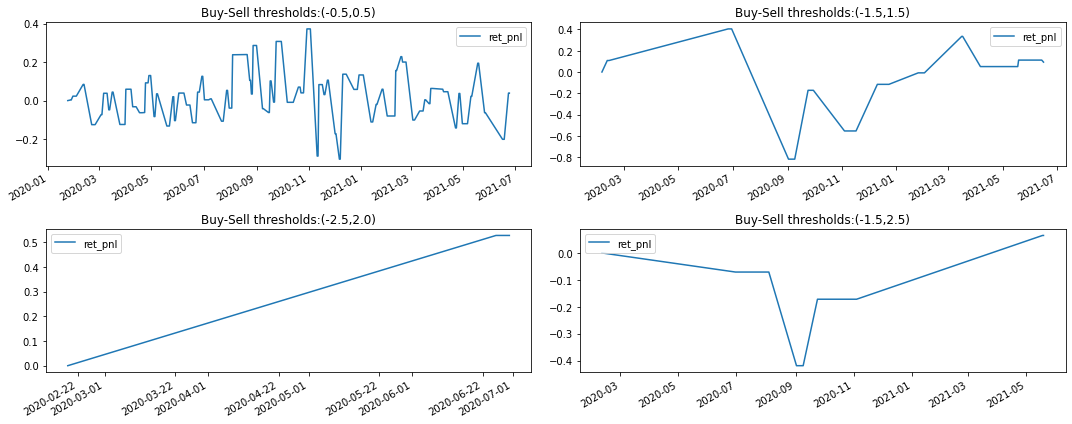

In [138]:
THRESHOLDS=[(-0.5,0.5),
            (-1.5,1.5),
            (-2.5,2.0),
            (-1.5,2.5),
            ]

fig, axes = plt.subplots(nrows = len(THRESHOLDS) // 2,
                       ncols = 2, figsize=(15, 6), )
fig.subplots_adjust(hspace = 0.4)
for i, (buy_threshold, sell_threshold) in enumerate(THRESHOLDS):
  strategy.start(lookback_intervals = 15, buy_threshold = buy_threshold, sell_threshold = sell_threshold)
  NG_retpnls=strategy.NG_retpnl
  ax=axes[i // 2, i % 2]
  ax.set_title('Buy-Sell thresholds:(%s,%s)'%(buy_threshold, sell_threshold))
  ax.grid(b=True, which='major', color='b', linestyle='-')
  NG_retpnls.plot(ax=ax)
  plt.tight_layout()